# Data Cleaning


The goal of this document is to show the process in which the data is transformed from the KT3 dataset into the format that will be used to answer the overall research quesiton:\
\
**How does the time spent on lectures impact the performance of students in online courses?**

In [1]:
import csv, os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = os.path.dirname(os.getcwd())

In [3]:
DATASET_PATH = os.path.join(BASE_DIR,"dataset","KT3")
CLEAN_DATASET_PATH = os.path.join(BASE_DIR,"cleaned_dataset")
CLEAN_DATASET_CSV_PATH = os.path.join(CLEAN_DATASET_PATH,"dataset.csv")

Here, the structure of where and how question answer data is stored is explored to extract the question answer to compare to the correct answer later on. From the exploration below, a few key takeaways can be inferred.

1. Question rows lie between rows detailing the opening and closing of a bundle. 
2. Bundles have one question each, but not all bundles contain questions. 
3. There can be multiple instances of one question, but only the last one counts when the problem is submitted.

In [4]:
for file_name in random.sample(os.listdir(DATASET_PATH),10):
    with open(os.path.join(DATASET_PATH,file_name),"r") as file:
        reader = csv.reader(file)
        next(reader) #for the header

        bundle_flag = 0
        to_print = dict()
        for line in reader:
            if line[2][0] == "b":
                bundle_flag = ~bundle_flag
                if not bundle_flag and len(to_print):
                    print(f'''Bundle {line[2]} contains questions {",".join([f"{value} instances of {key}" for key,value in to_print.items()])}''')
                    to_print = dict()
            if line[2][0] == "q" and bundle_flag:
                if not to_print.get(line[2],0):
                    to_print[line[2]] = 0
                to_print[line[2]] += 1


Bundle b3627 contains questions 1 instances of q5095
Bundle b2431 contains questions 1 instances of q3899
Bundle b4356 contains questions 1 instances of q5824
Bundle b62 contains questions 1 instances of q62
Bundle b39 contains questions 1 instances of q39
Bundle b5623 contains questions 1 instances of q8152
Bundle b8057 contains questions 1 instances of q11004
Bundle b52 contains questions 1 instances of q52
Bundle b5582 contains questions 1 instances of q8111
Bundle b5538 contains questions 1 instances of q8067
Bundle b8211 contains questions 2 instances of q11158
Bundle b5527 contains questions 1 instances of q8056
Bundle b91 contains questions 1 instances of q91
Bundle b163 contains questions 1 instances of q163
Bundle b8111 contains questions 1 instances of q11058
Bundle b5532 contains questions 1 instances of q8061
Bundle b195 contains questions 1 instances of q195
Bundle b100 contains questions 1 instances of q100
Bundle b8283 contains questions 1 instances of q11230
Bundle b110

Lectures are more straightforward. Opening a lecture follows with a row closing this lecture. Thus, to calculate the average time each student spends on lectures, the difference between the timestamps of the intial row and the row below (entering and exiting row) can be found, then averaged later on.

In [5]:
for file_name in random.sample(os.listdir(DATASET_PATH),10):
    with open(os.path.join(DATASET_PATH,file_name),"r") as file:
        reader = csv.reader(file)
        next(reader) #for the header

        for line in reader:
            if line[2][0] == "l":
                next_line = next(reader)
                print(f"{line[2]} start, {next_line[2]} end, difference in time: {int(next_line[0]) - int(line[0])}")
        print("---")
                

---
---
---
---
---
---
---
---
---
---


One concern that the code above raises is that some users may not have any lecture time at all. Counting these data points as "0 hours of lecture" may be inaccurate, as there is no data on how much time the student spends on lectures as they do not spend it with the app. Therefore, these datapoints are excluded.

Students who do not answer any questions with the system similarly are data points without sufficient data, and are removed.

In [6]:
included_data = []
num_removed = 0
for file_name in os.listdir(DATASET_PATH):
    file_path = os.path.join(DATASET_PATH,file_name)
    with open(file_path,"r") as file:
        reader = csv.reader(file)
        #to skip file header
        next(reader)

        conditions = {"lectures":0,"questions":0}
        for line in reader:
            if line[2]:
                if line[2][0] == "l":
                    conditions["lectures"] = 1
                elif line[2][0] == "q":
                    conditions["questions"] = 1

        if all(conditions.values()):        
            included_data.append(file_name)
        else:num_removed += 1
                
num_removed

255427

In [7]:
included_data[:2]

['u485334.csv', 'u384503.csv']

After performing this step, the data is then transformed into a dataset with the format
- UserID: The id of the student
- Lecture Hours: The total number of hours spent on lectures represented in milliseconds
- Correct Percent: The percentage of historical lifetime questions answered correctly with the application
- Questions Answered: The number of questions answered by the user
- Questions Correct: The number of questions answered correctly by the user

In [8]:
def transform_data(data):
    #create a key with questions and their corresponding correct answers
    question_key = {}
    with open(os.path.join(BASE_DIR,"dataset","questions.csv"),"r") as file:
        reader = csv.reader(file)
        next(reader) #for the header
        for line in reader:
            if str(line[3]) != "-1":
                question_key[line[0]] = line[3]

    to_return = {"UserID":[],"Lecture_Milliseconds":[],"Correct_Percent":[],"Questions_Answered":[],"Questions_Correct":[]}

    for file_name in data:
        id = file_name[:file_name.index(".")]
        to_return["UserID"].append(id)
        with open(os.path.join(DATASET_PATH,file_name),"r") as file:
            reader = csv.reader(file)
            next(reader) #for the header

            question_lock = 0
            prev_line = []

            # assume this will never be 0/0 because the code above removes all students with no questions answered
            num_correct = 0
            total_questions = 0
            tot_lecture_time = 0

            for line in reader:
                if line[2]:
                    if question_lock and line[2][0] != "q":
                        total_questions += 1
                        num_correct += int(prev_line[4] == question_key[prev_line[2]])
                        question_lock = 0
                    if line[2][0] == "q":
                        question_lock = 1
                    if line[2][0] == "l":
                        next_line = next(reader)
                        tot_lecture_time += int(next_line[0]) - int(line[0])
                    prev_line = line
            #just in case the last line is a question answer
            if prev_line[2][0] == "q":
                total_questions += 1
                num_correct += int(prev_line[4] == question_key[prev_line[2]])

            to_return["Lecture_Milliseconds"].append(tot_lecture_time)
            to_return["Correct_Percent"].append(num_correct / total_questions)
            to_return["Questions_Answered"].append(total_questions)
            to_return["Questions_Correct"].append(num_correct)
        
    to_return = pd.DataFrame(to_return)

    return to_return

In [9]:
if not os.path.exists(CLEAN_DATASET_CSV_PATH):
    df = transform_data(included_data)

In [10]:
df.head(5)

,UserID,Lecture_Milliseconds,Correct_Percent,Questions_Answered,Questions_Correct
0,u485334,456389,0.754237,118,89
1,u384503,190414,0.675000,80,54
2,u525828,389228,0.708609,151,107
3,u329291,200190,0.391304,46,18
4,u12223,249467,0.750000,144,108


In [11]:
df.describe()

,Lecture_Milliseconds,Correct_Percent,Questions_Answered,Questions_Correct
count,4.248800e+04,42488.000000,42488.00000,42488.000000
mean,4.688828e+06,0.606074,289.05491,190.400843
std,2.225739e+07,0.129110,560.35530,387.018073
min,6.400000e+01,0.000000,1.00000,0.000000
25%,2.182822e+05,0.545455,45.00000,26.000000
50%,7.027015e+05,0.628458,117.00000,74.000000
75%,2.915694e+06,0.691645,303.00000,197.000000
max,2.504055e+09,1.000000,31640.00000,24732.000000


<Axes: >

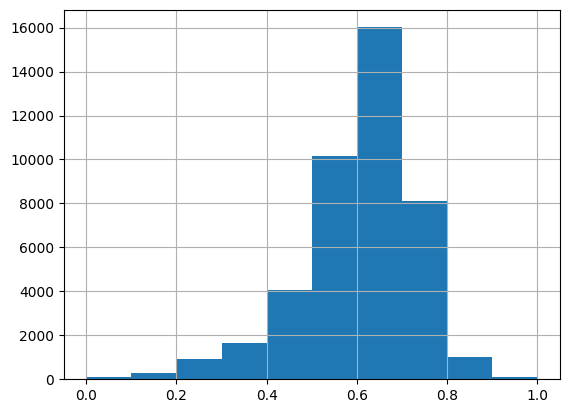

In [12]:
df["Correct_Percent"].hist()

<Axes: >

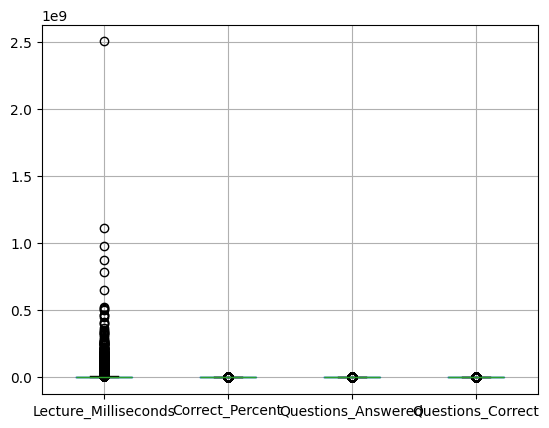

In [13]:
df.boxplot()

In [14]:
new_dataset_csv = os.path.join(BASE_DIR,"dataset","cleaned_dataset.csv")
df.to_csv(new_dataset_csv, index=False)
print("Written to CSV!")

Written to CSV!
